In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import keras
from keras_unet.models import custom_unet

2023-02-02 12:55:57.206740: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/Nathan Arnett Calcification'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')


In [4]:
images = np.load(images_file)
labels = np.load(labels_file)

In [5]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [6]:
p = np.random.permutation(len(images))

In [7]:
images = images[p]
labels = labels[p]

In [8]:
images = images.astype(np.float64)
labels = labels.astype(np.float64)

In [9]:
for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

In [10]:
images.shape

(503, 512, 512, 1)

In [11]:
labels.shape

(503, 512, 512, 1)

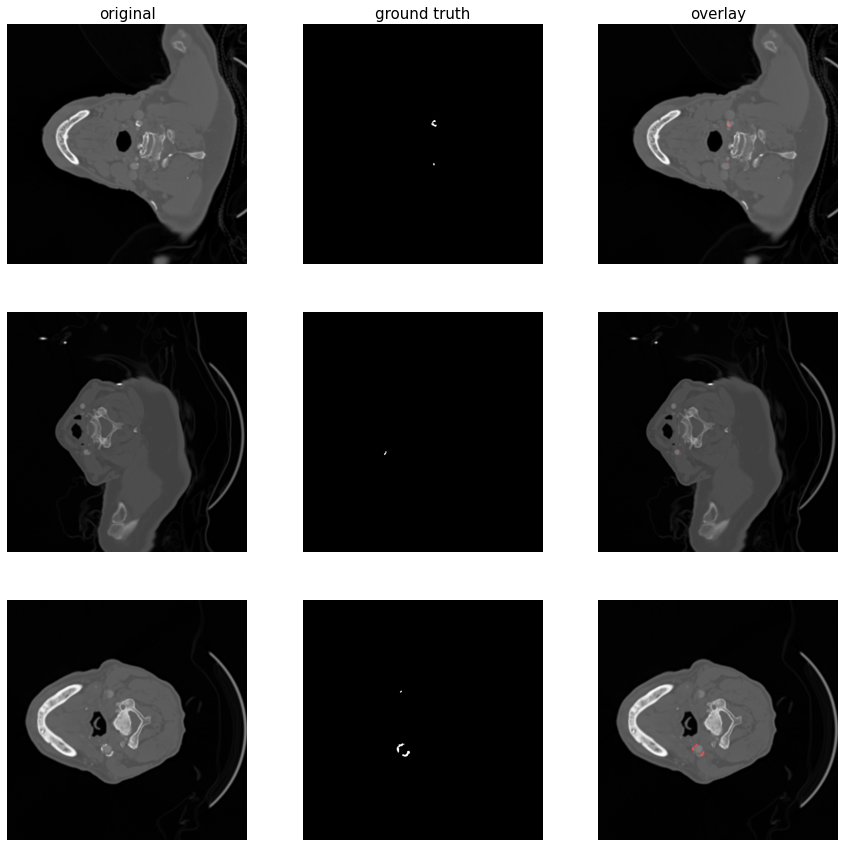

In [12]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=images, mask_imgs=labels, nm_img_to_plot=3, figsize=5)

In [13]:
X_train = images[0:300]
y_train = labels[0:300]
X_val = images[300:400]
y_val = labels[300:400]
X_test = images[400:]
y_test = labels[400:]

In [14]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

(2, 512, 512, 1) (2, 512, 512, 1)


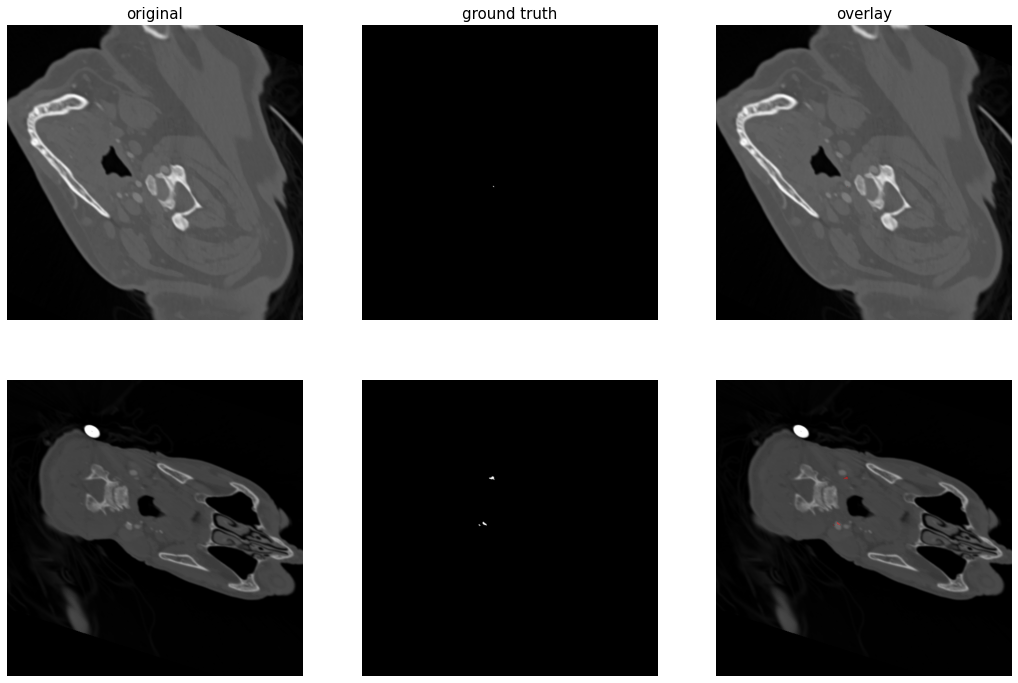

In [15]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [16]:
from keras_unet_collection import models, losses
import torch

model = models.swin_unet_2d((512, 512, 1), filter_num_begin=64,
                               n_labels=1, depth=4, stack_num_down=4, stack_num_up=4,
                               patch_size=(4, 4), num_heads=[4, 8, 16, 16],
                               window_size=[4, 4, 4, 4], num_mlp=512, 
                               output_activation='Sigmoid', shift_window=True, name='swin_unet')

#Softmax

2023-02-02 12:56:22.233456: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-02 12:56:22.327811: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:87:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-02 12:56:22.327852: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-02 12:56:22.327885: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-02 12:56:22.327901: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-02 12:56:22.334759: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2023-02-02 12:56:22.353255: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-02 12:56:22.355951: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:87:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-02 12:56:22.361115: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2023-02-02 12:56:22.361434: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-02 12:56:23.168269: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecuto

In [17]:
model.summary()

Model: "swin_unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
patch_extract (patch_extract)   (None, 16384, 16)    0           input_1[0][0]                    
__________________________________________________________________________________________________
patch_embedding (patch_embeddin (None, 16384, 64)    1049664     patch_extract[0][0]              
__________________________________________________________________________________________________
swin_transformer_block (SwinTra (None, 16384, 64)    83460       patch_embedding[0][0]            
____________________________________________________________________________________

In [18]:
from tensorflow.keras import optimizers
from keras_unet.metrics import iou, iou_thresholded, dice_coef
from keras_unet_collection import losses

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=[iou, iou_thresholded])

In [20]:
history = model.fit(X_train, 
                    y_train, 
                    batch_size=16, 
                    epochs=200,
                    validation_data=(X_val, y_val))

2023-02-02 12:56:39.189111: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-02 12:56:39.209198: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/200


2023-02-02 12:57:04.041097: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-02 12:57:05.151023: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-02 12:57:05.151377: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-02 12:57:05.287256: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-02-02 12:57:05.462560: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500
2023-02-02 12:57:06.182821: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-02-02 12:57:06.182845: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-02-02 12:57:06.18319

19/19 [==============================] - 46s 1s/step - loss: 0.0984 - iou: 7.1219e-04 - iou_thresholded: 8.5338e-04 - val_loss: 0.0103 - val_iou: 0.0012 - val_iou_thresholded: 0.0012
Epoch 2/200
19/19 [==============================] - 16s 837ms/step - loss: 0.0108 - iou: 8.7368e-04 - iou_thresholded: 0.0011 - val_loss: 0.0083 - val_iou: 7.6372e-04 - val_iou_thresholded: 0.0012
Epoch 3/200
19/19 [==============================] - 14s 749ms/step - loss: 0.0054 - iou: 9.4546e-04 - iou_thresholded: 0.0011 - val_loss: 0.0040 - val_iou: 0.0011 - val_iou_thresholded: 0.0012
Epoch 4/200
19/19 [==============================] - 14s 736ms/step - loss: 0.0028 - iou: 0.0013 - iou_thresholded: 0.0011 - val_loss: 0.0030 - val_iou: 0.0013 - val_iou_thresholded: 0.0012
Epoch 5/200
19/19 [==============================] - 14s 750ms/step - loss: 0.0063 - iou: 0.0011 - iou_thresholded: 0.0013 - val_loss: 0.0069 - val_iou: 0.0010 - val_iou_thresholded: 0.0012
Epoch 6/200
19/19 [==========================

19/19 [==============================] - 14s 742ms/step - loss: 3.7676e-04 - iou: 0.3646 - iou_thresholded: 0.4588 - val_loss: 6.8759e-04 - val_iou: 0.3029 - val_iou_thresholded: 0.3814
Epoch 44/200
19/19 [==============================] - 14s 731ms/step - loss: 3.8459e-04 - iou: 0.3542 - iou_thresholded: 0.4385 - val_loss: 7.0930e-04 - val_iou: 0.2890 - val_iou_thresholded: 0.3362
Epoch 45/200
19/19 [==============================] - 14s 742ms/step - loss: 3.5249e-04 - iou: 0.3838 - iou_thresholded: 0.4776 - val_loss: 6.6677e-04 - val_iou: 0.3180 - val_iou_thresholded: 0.3936
Epoch 46/200
19/19 [==============================] - 14s 741ms/step - loss: 3.4247e-04 - iou: 0.3928 - iou_thresholded: 0.4977 - val_loss: 6.6856e-04 - val_iou: 0.3135 - val_iou_thresholded: 0.3968
Epoch 47/200
19/19 [==============================] - 14s 737ms/step - loss: 3.3087e-04 - iou: 0.4010 - iou_thresholded: 0.5012 - val_loss: 6.5911e-04 - val_iou: 0.3281 - val_iou_thresholded: 0.3910
Epoch 48/200
19/19

19/19 [==============================] - 14s 742ms/step - loss: 1.0936e-04 - iou: 0.7128 - iou_thresholded: 0.8287 - val_loss: 6.9146e-04 - val_iou: 0.4483 - val_iou_thresholded: 0.4859
Epoch 85/200
19/19 [==============================] - 14s 735ms/step - loss: 1.0278e-04 - iou: 0.7256 - iou_thresholded: 0.8400 - val_loss: 7.0526e-04 - val_iou: 0.4531 - val_iou_thresholded: 0.4895
Epoch 86/200
19/19 [==============================] - 14s 736ms/step - loss: 9.2402e-05 - iou: 0.7400 - iou_thresholded: 0.8633 - val_loss: 7.4486e-04 - val_iou: 0.4506 - val_iou_thresholded: 0.4830
Epoch 87/200
19/19 [==============================] - 14s 731ms/step - loss: 8.5954e-05 - iou: 0.7526 - iou_thresholded: 0.8784 - val_loss: 7.3753e-04 - val_iou: 0.4537 - val_iou_thresholded: 0.4841
Epoch 88/200
19/19 [==============================] - 14s 745ms/step - loss: 8.3721e-05 - iou: 0.7614 - iou_thresholded: 0.8795 - val_loss: 7.1904e-04 - val_iou: 0.4623 - val_iou_thresholded: 0.4931
Epoch 89/200
19/19

19/19 [==============================] - 14s 737ms/step - loss: 5.8798e-05 - iou: 0.8365 - iou_thresholded: 0.9124 - val_loss: 9.2878e-04 - val_iou: 0.4730 - val_iou_thresholded: 0.4868
Epoch 126/200
19/19 [==============================] - 14s 740ms/step - loss: 5.0055e-05 - iou: 0.8511 - iou_thresholded: 0.9315 - val_loss: 9.0273e-04 - val_iou: 0.4722 - val_iou_thresholded: 0.4904
Epoch 127/200
19/19 [==============================] - 14s 735ms/step - loss: 4.2514e-05 - iou: 0.8647 - iou_thresholded: 0.9481 - val_loss: 9.2261e-04 - val_iou: 0.4762 - val_iou_thresholded: 0.4949
Epoch 128/200
19/19 [==============================] - 14s 742ms/step - loss: 3.5694e-05 - iou: 0.8799 - iou_thresholded: 0.9652 - val_loss: 9.2379e-04 - val_iou: 0.4770 - val_iou_thresholded: 0.4948
Epoch 129/200
19/19 [==============================] - 14s 737ms/step - loss: 3.2164e-05 - iou: 0.8893 - iou_thresholded: 0.9744 - val_loss: 9.3070e-04 - val_iou: 0.4811 - val_iou_thresholded: 0.4973
Epoch 130/200


19/19 [==============================] - 14s 738ms/step - loss: 1.7907e-04 - iou: 0.7020 - iou_thresholded: 0.7528 - val_loss: 0.0010 - val_iou: 0.4372 - val_iou_thresholded: 0.4544
Epoch 167/200
19/19 [==============================] - 14s 746ms/step - loss: 1.5004e-04 - iou: 0.7218 - iou_thresholded: 0.7751 - val_loss: 9.6732e-04 - val_iou: 0.4364 - val_iou_thresholded: 0.4567
Epoch 168/200
19/19 [==============================] - 14s 733ms/step - loss: 1.3536e-04 - iou: 0.7428 - iou_thresholded: 0.7951 - val_loss: 9.3468e-04 - val_iou: 0.4576 - val_iou_thresholded: 0.4744
Epoch 169/200
19/19 [==============================] - 14s 752ms/step - loss: 9.8463e-05 - iou: 0.7770 - iou_thresholded: 0.8401 - val_loss: 9.1405e-04 - val_iou: 0.4701 - val_iou_thresholded: 0.4908
Epoch 170/200
19/19 [==============================] - 14s 735ms/step - loss: 6.2699e-05 - iou: 0.8310 - iou_thresholded: 0.8980 - val_loss: 9.2299e-04 - val_iou: 0.4743 - val_iou_thresholded: 0.4907
Epoch 171/200
19/1

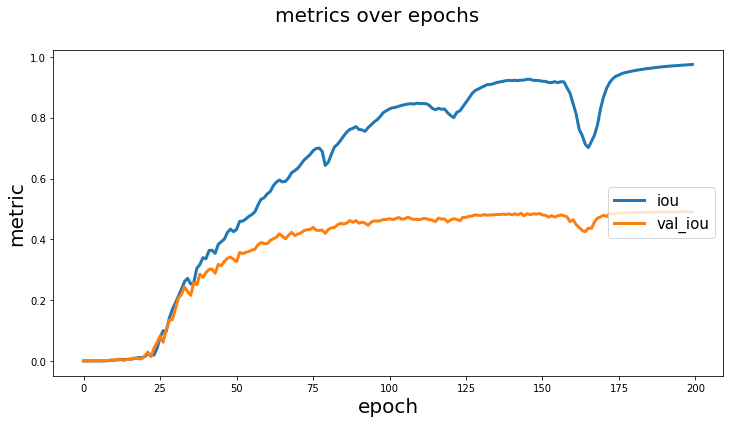

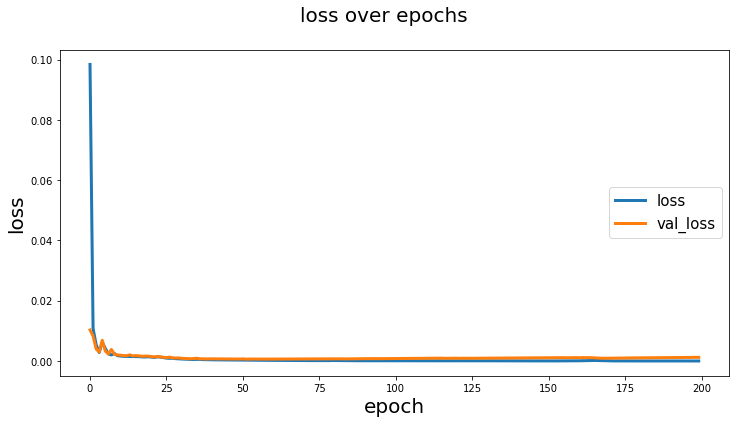

In [21]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [22]:
y_pred = model.predict(X_test)

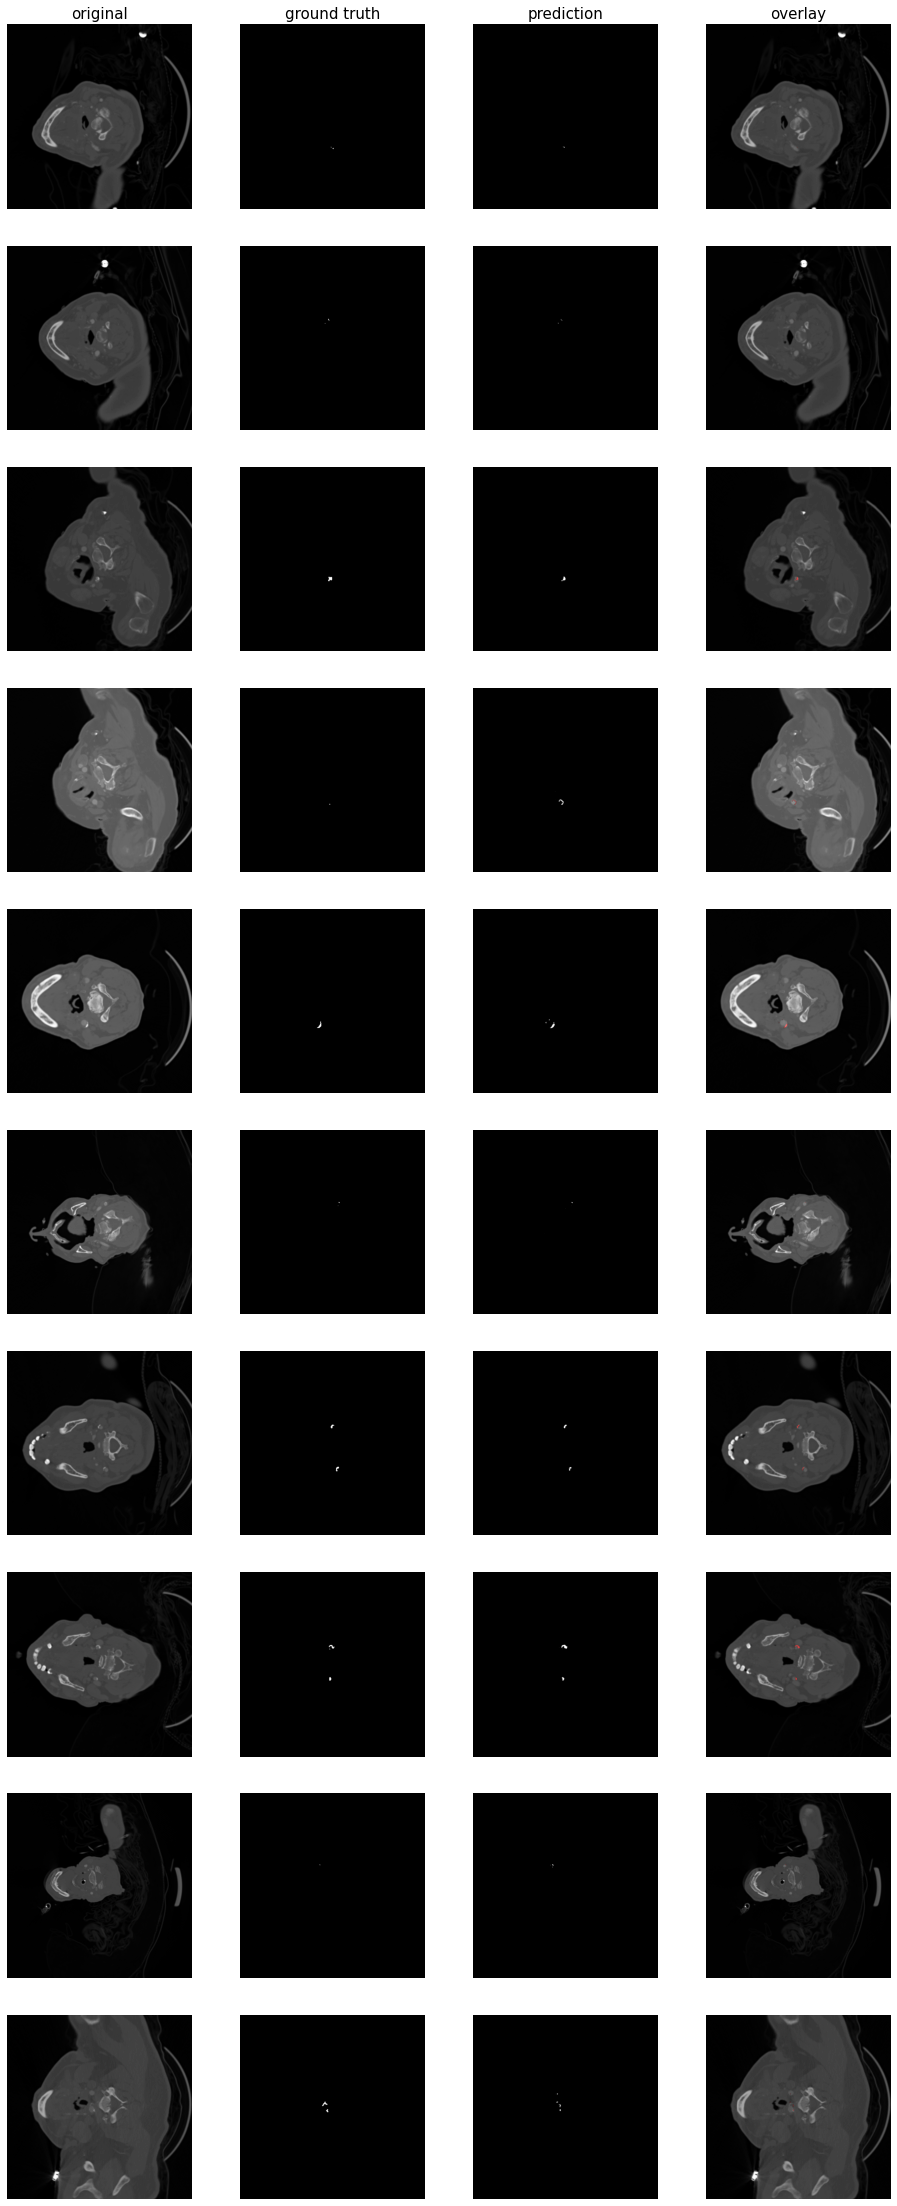

In [23]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=10)

In [24]:
loss, iou, iou_thresholded = model.evaluate(X_test, y_test)

4/4 [==============================] - 2s 355ms/step - loss: 7.2724e-04 - iou: 0.4802 - iou_thresholded: 0.4904
